#**HELPER FUNCTION**

In [124]:
import pandas as pd
import random


# 1. Train-Test-Split
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df


# 2. Distinguish categorical and continuous features
def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types


# 3. Accuracy
def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy

#**DECISION TREE FUNCTIONS**

In [125]:
import numpy as np
import pandas as pd
import random

# 1.1 Data pure?
def check_purity(data):
    
    label_column = data[:, -1]
    unique_classes = np.unique(label_column)

    if len(unique_classes) == 1:
        return True
    else:
        return False

    
# 1.2 Classify
def classify_data(data):
    
    label_column = data[:, -1]
    unique_classes, counts_unique_classes = np.unique(label_column, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification


# 1.3 Potential splits?
def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1))    # excluding the last column which is the label
    
    if random_subspace and random_subspace <= len(column_indices):
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    for column_index in column_indices:          
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits


# 1.4 Lowest Overall Entropy?
def calculate_entropy(data):
    
    label_column = data[:, -1]
    _, counts = np.unique(label_column, return_counts=True)

    probabilities = counts / counts.sum()
    entropy = sum(probabilities * -np.log2(probabilities))
     
    return entropy


def calculate_overall_entropy(data_below, data_above):
    
    n = len(data_below) + len(data_above)
    p_data_below = len(data_below) / n
    p_data_above = len(data_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(data_below) 
                      + p_data_above * calculate_entropy(data_above))
    
    return overall_entropy


def determine_best_split(data, potential_splits):
    
    overall_entropy = 9999
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            data_below, data_above = split_data(data, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(data_below, data_above)
            
            if current_overall_entropy <= overall_entropy:
                overall_entropy = current_overall_entropy
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value


# 1.5 Split data
def split_data(data, split_column, split_value):
    
    split_column_values = data[:, split_column]

    type_of_feature = FEATURE_TYPES[split_column]
    if type_of_feature == "continuous":
        data_below = data[split_column_values <= split_value]
        data_above = data[split_column_values >  split_value]
    
    # feature is categorical   
    else:
        data_below = data[split_column_values == split_value]
        data_above = data[split_column_values != split_value]
    
    return data_below, data_above


# 2. Decision Tree Algorithm
def decision_tree_algorithm(df, counter=0, min_samples=2, max_depth=5, random_subspace=None):
    
    # data preparations
    if counter == 0:
        global COLUMN_HEADERS, FEATURE_TYPES
        COLUMN_HEADERS = df.columns
        FEATURE_TYPES = determine_type_of_feature(df)
        data = df.values
    else:
        data = df           
    
    
    # base cases
    if (check_purity(data)) or (len(data) < min_samples) or (counter == max_depth):
        classification = classify_data(data)
        
        return classification

    
    # recursive part
    else:    
        counter += 1

        # helper functions 
        potential_splits = get_potential_splits(data, random_subspace)
        split_column, split_value = determine_best_split(data, potential_splits)
        data_below, data_above = split_data(data, split_column, split_value)
        
        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            classification = classify_data(data)
            return classification
        
        # determine question
        feature_name = COLUMN_HEADERS[split_column]
        type_of_feature = FEATURE_TYPES[split_column]
        if type_of_feature == "continuous":
            question = "{} <= {}".format(feature_name, split_value)
            
        # feature is categorical
        else:
            question = "{} = {}".format(feature_name, split_value)
        
        # instantiate sub-tree
        sub_tree = {question: []}
        
        # find answers (recursion)
        yes_answer = decision_tree_algorithm(data_below, counter, min_samples, max_depth, random_subspace)
        no_answer = decision_tree_algorithm(data_above, counter, min_samples, max_depth, random_subspace)
        
        # If the answers are the same, then there is no point in asking the qestion.
        # This could happen when the data is classified even though it is not pure
        # yet (min_samples or max_depth base case).
        if yes_answer == no_answer:
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree


# 3. Make predictions
# 3.1 One example
def predict_example(example, tree):
    question = list(tree.keys())[0]
    feature_name, comparison_operator, value = question.split(" ")

    # ask question
    if comparison_operator == "<=":
        if example[feature_name] <= float(value):
            answer = tree[question][0]
        else:
            answer = tree[question][1]
    
    # feature is categorical
    else:
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]

    # base case
    if not isinstance(answer, dict):
        return answer
    
    # recursive part
    else:
        residual_tree = answer
        return predict_example(example, residual_tree)

    
# 3.2 All examples of the test data
def decision_tree_predictions(test_df, tree):
    predictions = test_df.apply(predict_example, args=(tree,), axis=1)
    return predictions

# 3.2 All examples of a dataframe
def make_predictions(df, tree):
    
    if len(df) != 0:
        predictions = df.apply(predict_example, args=(tree,), axis=1)
    else:
        # "df.apply()"" with empty dataframe returns an empty dataframe,
        # but "predictions" should be a series instead
        predictions = pd.Series()
        
    return predictions

#**RANDOM FOREST CLASSIFIER**

In [126]:
def bootstrapping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    
    return df_bootstrapped

def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    forest = []
    for i in range(n_trees):
        df_bootstrapped = bootstrapping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
    return forest

def random_forest_predictions(test_df, forest):
    df_predictions = {}
    for i in range(len(forest)):
        column_name = "tree_{}".format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    return random_forest_predictions

#**MODEL TRAINING ON DATASET**

In [127]:
#Import libraries for plotting 
from matplotlib import pyplot as plt
import seaborn as sns

In [128]:
df = pd.read_csv("/content/TitanicData.csv")
df["label"] = df.Survived

# handling missing values
median_age = df.Age.median()

df = df.fillna({"Age": median_age})

In [129]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,label
0,0,3,22.0,1,0,7.2500,1,0
1,1,1,38.0,1,0,71.2833,0,1
2,1,3,26.0,0,0,7.9250,0,1
3,1,1,35.0,1,0,53.1000,0,1
4,0,3,35.0,0,0,8.0500,1,0


0    424
1    288
Name: label, dtype: int64


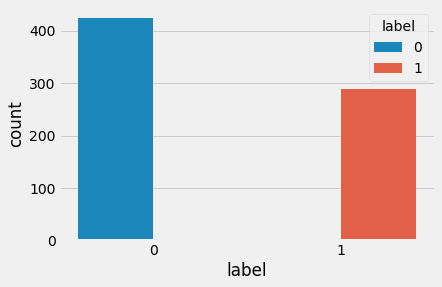

In [130]:
# tARGET DISTRIBUTION PLOT
print(df['label'].value_counts()) 
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='label', data=df, hue='label')

###**TRAIN-TEST SPLIT**

In [131]:
def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [132]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.2)

In [133]:
train_df.shape,test_df.shape

((570, 8), (142, 8))

###**MODEL BUILDING AND PREDICTION**

In [134]:
forest = random_forest_algorithm(train_df, n_trees=5, n_bootstrap=50, n_features=2, dt_max_depth=3)
train_predictions = random_forest_predictions(train_df, forest)
predictions = random_forest_predictions(test_df, forest)

train_accuracy = calculate_accuracy(train_predictions, train_df.label)
accuracy = calculate_accuracy(test_df.label, test_df.label)

### **MODEL EVALUATION**

In [135]:
print("Train Accuracy = {}".format(train_accuracy))
print("Test Accuracy = {}".format(accuracy))

Train Accuracy = 1.0
Test Accuracy = 1.0


In [141]:
def classification_report(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    fp = sum((y_true == 0) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fn = sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1_score))

def precision(y_true, y_pred):
    true_positives = sum((y_true == 1) & (y_pred == 1))
    false_positives = sum((y_true == 0) & (y_pred == 1))
    precision = true_positives / (true_positives + false_positives + 1e-7)
    return precision


def recall(y_true, y_pred):
    true_positives = sum((y_true == 1) & (y_pred == 1))
    false_negative = sum((y_true == 1) & (y_pred == 0))
    recall = true_positives / (true_positives + false_negative + 1e-7) 
    return recall

def f1_score(y_true, y_pred):
    tp = sum((y_true == 1) & (y_pred == 1))
    fp = sum((y_true == 0) & (y_pred == 1))
    tn = sum((y_true == 0) & (y_pred == 0))
    fn = sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
    return f1_score


In [142]:
# getting all the performane metrics and stored it in a dataframe

scores = pd.DataFrame(columns=['Model','Train_Accuracy','Train_Recall','Train_Precision','Train_F1_Score','Test_Accuracy','Test_Recall','Test_Precision','Test_F1_Score'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    train_accuracy = calculate_accuracy(train_actual,train_predicted)
    train_recall   = recall(train_actual,train_predicted)
    train_precision= precision(train_actual,train_predicted)
    train_f1score  = f1_score(train_actual,train_predicted)
    test_accuracy = calculate_accuracy(test_actual,test_predicted)
    test_recall   = recall(test_actual,test_predicted)
    test_precision= precision(test_actual,test_predicted)
    test_f1score  = f1_score(test_actual,test_predicted)
    dataframe = dataframe.append(pd.Series([model_description, train_accuracy,train_recall,train_precision,train_f1score,
                                            test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

In [143]:

# Used a customised function for getting reports
scores = get_metrics(train_df.label,train_predictions,test_df.label,predictions,"RandomforestClassifier",scores)
scores

,Model,Train_Accuracy,Train_Recall,Train_Precision,Train_F1_Score,Test_Accuracy,Test_Recall,Test_Precision,Test_F1_Score
0,RandomforestClassifier,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [144]:
classification_report(test_df.label, predictions)

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
